In [1]:
import torch
import torch.nn.functional as F
import numpy as np

from torch.utils.data import Dataset, DataLoader 
from tqdm import tqdm

from dataloader import *

# Visualization
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns

# Setting random seed for consistent behavior
import random
train_seed = 72 - 3
random.seed(train_seed)
torch.manual_seed(train_seed)
torch.cuda.manual_seed(train_seed)
torch.backends.cudnn.deterministic = True
random.seed(train_seed)
np.random.seed(train_seed)

# Environment & Data Configuration

In [2]:
torch.autograd.set_detect_anomaly(True)

n_nodes = 9
#batch_size = 16        # Note: in og CML trajectory length == batch_size; in POCML this should be decoupled
n_obs = 9
trajectory_length = 9  # numer of node visits in a trajectory
num_desired_trajectories= 20

# choose env from "random", "small world" or "dead ends"
# TODO devouple batch_size from trajectory length for GraphEnv
# env = GraphEnv(n_nodes=n_nodes, n_items=n_obs, env='regular', action_type = "regular", batch_size=trajectory_length, num_desired_trajectories=num_desired_trajectories, unique = True)

env = GraphEnv( n_items=n_nodes,                     # number of possible observations
                env='grid', 
                batch_size=trajectory_length, 
                num_desired_trajectories=num_desired_trajectories, 
                device=None, 
                unique=True,                         # each state is assigned a unique observation if true
                args = {"rows": 3, "cols": 3}
            )

#dataset = RandomWalkDataset(env.adj_matrix, trajectory_length, num_desired_trajectories, n_obs, env.items)
train_dataset = env.dataset.data

env.gen_dataset()
test_dataset = env.dataset.data

train_dataloader = DataLoader(train_dataset, batch_size=1, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=True)

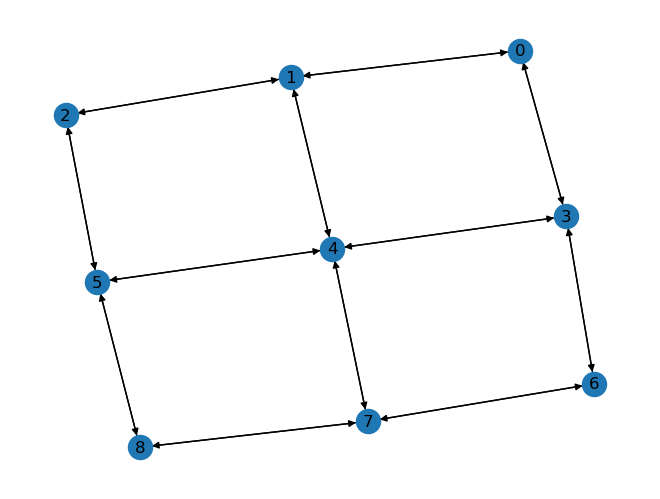

number of actions: 4
Sample trajectory:
tensor([[[4, 1, 7],
         [7, 0, 4],
         [4, 0, 1],
         [1, 1, 4],
         [4, 2, 3],
         [3, 3, 4],
         [4, 2, 3],
         [3, 3, 4]]])
S-O mapping:
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8])
Adjacency Matrix:
tensor([[0., 1., 0., 1., 0., 0., 0., 0., 0.],
        [1., 0., 1., 0., 1., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 1., 0., 0., 0.],
        [1., 0., 0., 0., 1., 0., 1., 0., 0.],
        [0., 1., 0., 1., 0., 1., 0., 1., 0.],
        [0., 0., 1., 0., 1., 0., 0., 0., 1.],
        [0., 0., 0., 1., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 1., 0., 1., 0., 1.],
        [0., 0., 0., 0., 0., 1., 0., 1., 0.]])
action-to-node:
{1: tensor([5, 8]), 3: tensor([7, 8]), 2: tensor([8, 7]), 0: tensor([8, 5])}
node-to-action-matrix:
tensor([[-1,  3, -1,  1, -1, -1, -1, -1, -1],
        [ 2, -1,  3, -1,  1, -1, -1, -1, -1],
        [-1,  2, -1, -1, -1,  1, -1, -1, -1],
        [ 0, -1, -1, -1,  3, -1,  1, -1, -1],
        [-1,  0,

In [3]:
adj = env.adj_matrix

# Assuming you have the adjacency matrix stored in the variable "adj"
G = nx.from_numpy_array(adj.numpy().astype(float), create_using = nx.DiGraph)

# Draw the graph using seaborn
# sns.set()
seed = 31 # Consistent graph shape across runs
pos = nx.spring_layout(G, seed=seed)
nx.draw(G, pos = pos, with_labels=True)
# Show the plot
plt.show()

print(f"number of actions: {env.n_actions}")

print("Sample trajectory:")
for trajectory in train_dataloader:
    print(trajectory)
    break

print("S-O mapping:")
print(env.items)
print("action-to-node:")
print(env.action_to_node)
print("node-to-action-matrix:")
print(env.node_to_action_matrix)
print("affordance / node - to action:")
print(env.affordance)

# Model & Trainer Config 

In [4]:
# Our code
from trainer import POCMLTrainer
from model import POCML

# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

state_dim = 500
random_feature_dim = 5000
epochs = 30

model = POCML(n_obs = env.n_items,
                n_states = env.size,
                n_actions = env.n_actions,
                state_dim = state_dim,
                random_feature_dim = random_feature_dim,
                alpha = 1,
                beta = 8,
                memory_bypass=True,
                decay = 0.9)
    
trainer = POCMLTrainer(model=model, 
                       train_loader = train_dataloader,
                       lr_Q_o = 0.1, 
                       lr_V_o = 0.01, 
                       lr_Q_s = 0., 
                       lr_V_s = 0., 
                       lr_all = 1, 
                       mem_rewweight_rate = 1.0, 
                       normalize = False,
                       )

loss_record = np.array(trainer.train(epochs)).reshape(epochs,-1)

Epochs:   0%|          | 0/30 [00:00<?, ?it/s]

Current Trajectory tensor([[1, 2, 0],
        [0, 3, 1],
        [1, 2, 0],
        [0, 1, 3],
        [3, 0, 0],
        [0, 1, 3],
        [3, 3, 4],
        [4, 1, 7]])
initial state: tensor(1)
Print initial score tensor([3.1263, 7.9995, 2.8302, 2.6869, 2.8493, 3.0876, 2.8769, 2.7837, 3.1813])
Obs similarity
 tensor([[1.0000, 0.3908, 0.3794, 0.4000, 0.3852, 0.4310, 0.3479, 0.3812, 0.4345],
        [0.3908, 1.0000, 0.3538, 0.3359, 0.3562, 0.3860, 0.3596, 0.3480, 0.3977],
        [0.3794, 0.3538, 1.0000, 0.3937, 0.3706, 0.3490, 0.3330, 0.3759, 0.3671],
        [0.4000, 0.3359, 0.3937, 1.0000, 0.3838, 0.3679, 0.3588, 0.3710, 0.3624],
        [0.3852, 0.3562, 0.3706, 0.3838, 1.0000, 0.3723, 0.3396, 0.3951, 0.3719],
        [0.4310, 0.3860, 0.3490, 0.3679, 0.3723, 1.0000, 0.3418, 0.3843, 0.4020],
        [0.3479, 0.3596, 0.3330, 0.3588, 0.3396, 0.3418, 1.0000, 0.3725, 0.3612],
        [0.3812, 0.3480, 0.3759, 0.3710, 0.3951, 0.3843, 0.3725, 1.0000, 0.4158],
        [0.4345, 0.3977, 0.367

In [ ]:
print("State similarities:\n", model.get_state_similarities())
print("Action similarities:\n", model.get_action_similarities())

State similarities:
 tensor([[ 5.7474,  5.6935,  0.4845,  4.7483,  4.6473,  4.3936,  3.6309,  3.4730,
          3.3506],
        [ 5.6935,  6.6376,  0.9350,  4.5235,  5.7499,  6.4076,  3.2162,  4.1466,
          5.0402],
        [ 0.4845,  0.9350,  2.6168, -0.7717, -0.2077, -0.0346, -2.1766, -1.8014,
         -1.4219],
        [ 4.7483,  4.5235, -0.7717,  4.9273,  4.6329,  4.4554,  5.1275,  4.8962,
          4.6767],
        [ 4.6473,  5.7499, -0.2077,  4.6329,  6.1048,  7.1463,  4.6186,  5.8378,
          6.9718],
        [ 4.3936,  6.4076, -0.0346,  4.4554,  7.1463,  9.0673,  4.5276,  6.7635,
          8.8409],
        [ 3.6309,  3.2162, -2.1766,  5.1275,  4.6186,  4.5276,  6.8014,  6.4895,
          6.1629],
        [ 3.4731,  4.1466, -1.8014,  4.8962,  5.8378,  6.7635,  6.4895,  7.3750,
          8.1637],
        [ 3.3506,  5.0402, -1.4219,  4.6767,  6.9718,  8.8409,  6.1629,  8.1637,
          9.9918]])
Action similarities:
 tensor([[ 1.0000, -0.9999, -0.0856,  0.0662],
        [-

In [ ]:
import evaluate

print("Train accuracy:", evaluate.accuracy(model, train_dataloader))
print("Test accuracy:", evaluate.accuracy(model, test_dataloader))

Train accuracy: 0.1625
Test accuracy: 0.175


In [ ]:
from sklearn.manifold import MDS

def visualize(distances, legend:str ="Node"):
    mds = MDS(n_components =2)
    positions = mds.fit_transform(distances)

    plt.figure(figsize=(8, 6))
    plt.scatter(positions[:, 0], positions[:, 1])

    # Optional: Annotate the points
    for i, (x, y) in enumerate(positions):
        plt.text(x, y, f'{legend} {i}', fontsize=12)

    plt.title('Graph Visualization using MDS')
    plt.xlabel('Dimension 1')
    plt.ylabel('Dimension 2')
    plt.grid(True)
    plt.show()

/home/zhuowen/anaconda3/lib/python3.11/site-packages/sklearn/manifold/_mds.py:601: UserWarning: The MDS API has changed. ``fit`` now constructs an dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity='precomputed'``.
  warnings.warn(
/home/zhuowen/anaconda3/lib/python3.11/site-packages/sklearn/manifold/_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


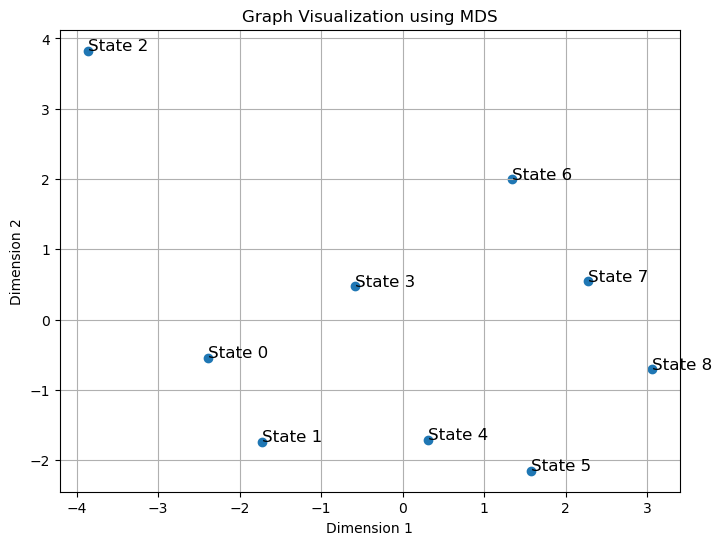

In [ ]:
visualize(model.get_state_differences().numpy(), legend = "State")

/home/zhuowen/anaconda3/lib/python3.11/site-packages/sklearn/manifold/_mds.py:601: UserWarning: The MDS API has changed. ``fit`` now constructs an dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity='precomputed'``.
  warnings.warn(
/home/zhuowen/anaconda3/lib/python3.11/site-packages/sklearn/manifold/_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


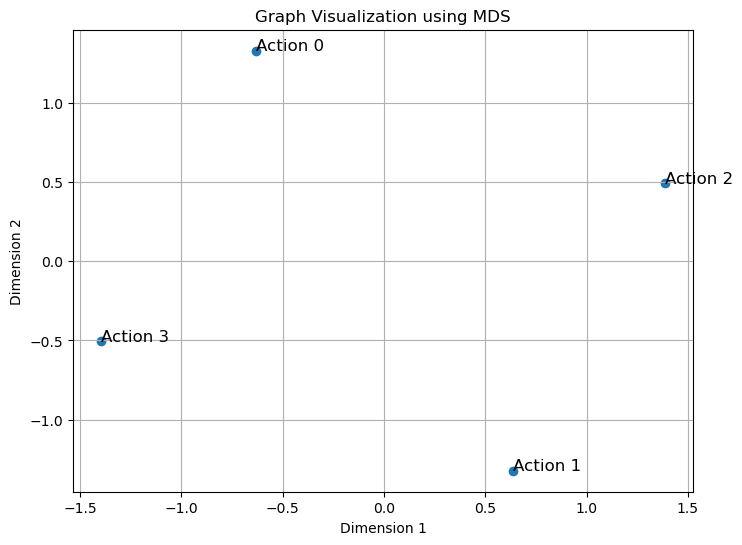

In [ ]:
visualize(model.get_action_differences().numpy(), "Action")

In [ ]:
print((model.M.T @ model.M.conj()).real)

tensor([[ 1.0000,  0.6091,  0.0118,  0.5499,  0.2523,  0.0240,  0.0577,  0.0206,
         -0.0014],
        [ 0.6091,  1.0000,  0.0143,  0.2963,  0.5236,  0.2074,  0.0261,  0.0423,
          0.0138],
        [ 0.0118,  0.0143,  1.0000, -0.0051,  0.0088,  0.0053, -0.0179,  0.0027,
          0.0012],
        [ 0.5499,  0.2963, -0.0051,  1.0000,  0.4128,  0.0655,  0.4727,  0.2579,
          0.0351],
        [ 0.2523,  0.5236,  0.0088,  0.4128,  1.0000,  0.6412,  0.1700,  0.4055,
          0.3163],
        [ 0.0240,  0.2074,  0.0053,  0.0655,  0.6412,  1.0000,  0.0329,  0.2447,
          0.5008],
        [ 0.0577,  0.0261, -0.0179,  0.4727,  0.1700,  0.0329,  1.0000,  0.5487,
          0.0955],
        [ 0.0206,  0.0423,  0.0027,  0.2579,  0.4055,  0.2447,  0.5487,  1.0000,
          0.5950],
        [-0.0014,  0.0138,  0.0012,  0.0351,  0.3163,  0.5008,  0.0955,  0.5950,
          0.9999]])


Text(0.5, 0, 'Epochs')

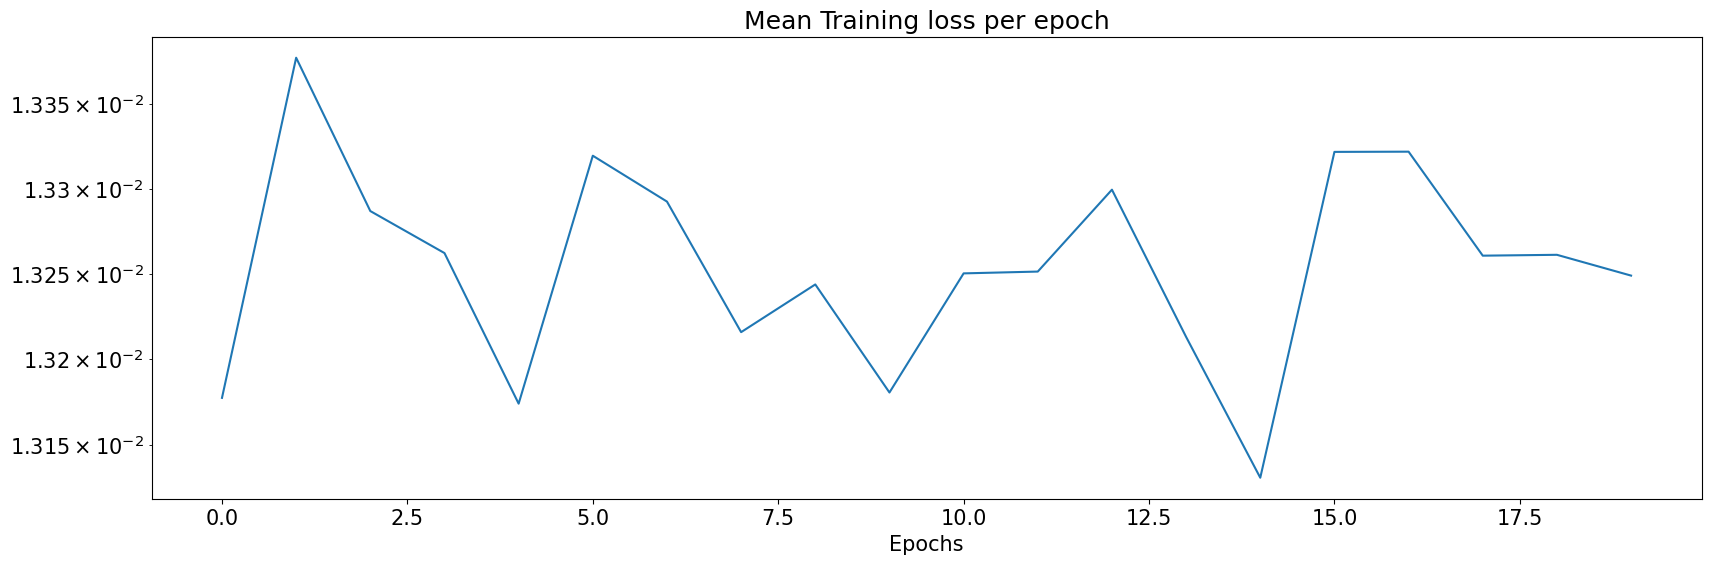

In [ ]:
# our trainer loss plot - flattened 

plt.rcParams['font.size'] = 15
plt.figure(figsize=(20, 6))
plt.plot(np.mean(loss_record, axis=1)/(env.num_desired_trajectories * (env.batch_size-1) ))
plt.yscale('log')
plt.title('Mean Training loss per epoch') # mean over the # trajectory and # steps in trajectory 
plt.xlabel('Epochs')

[  0.1   1.   10.  100. ]


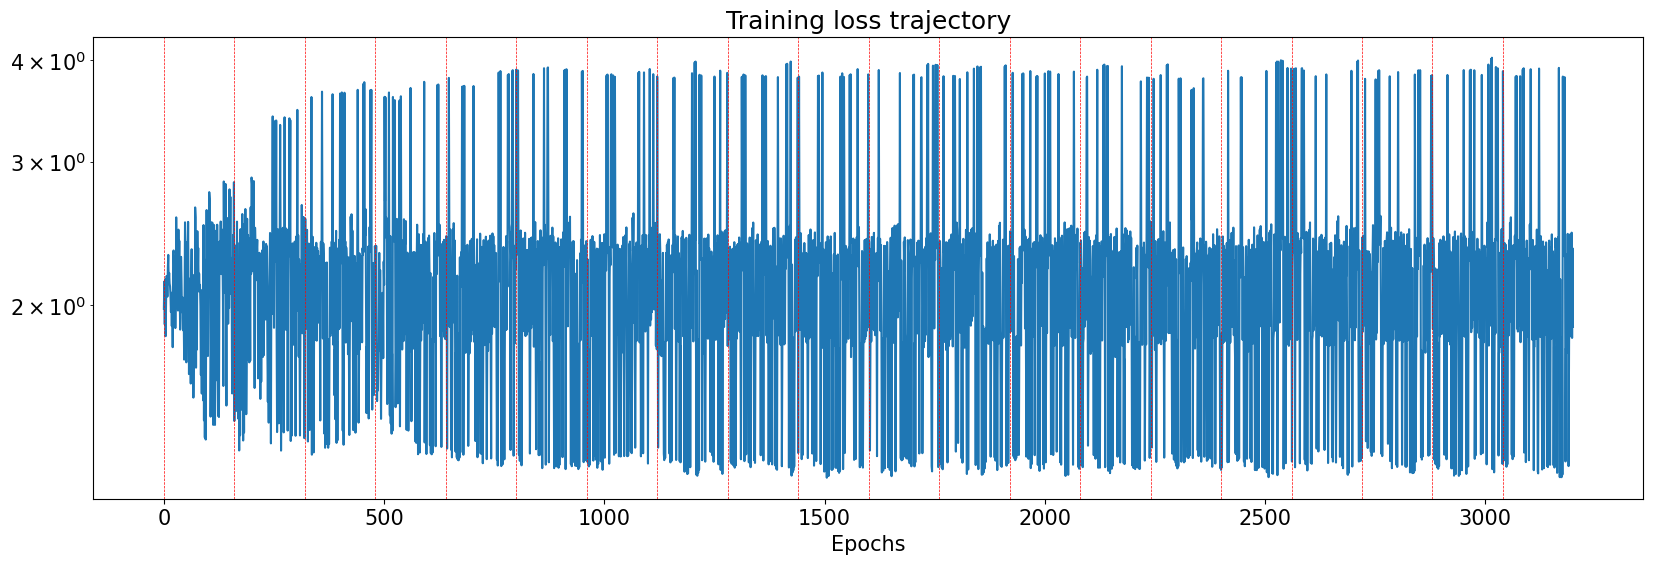

In [ ]:
# our trainer loss plot - flattened 

plt.rcParams['font.size'] = 15
plt.figure(figsize=(20, 6))
plt.plot(loss_record.reshape(-1))
plt.yscale('log')
plt.title('Training loss trajectory') # mean over the # trajectory and # steps in trajectory 
plt.xlabel('Epochs')

# Get the current y-ticks
yticks = plt.yticks()[0]

print(yticks)

# Add vertical lines at each multiple of 5

for i in range(0, len(loss_record.reshape(-1)), num_desired_trajectories * (trajectory_length-1)):
    plt.axvline(x=i, color='red', linestyle='--', linewidth=0.5)



In [ ]:

device = torch.device("cpu")

# CML 
def test_model(model, env, print_results=True):
    N_nodes = model.o_size
    dis = []
    D_dis = []
    N_goal = 1000
    adj_matrix_tensor = env.adj_matrix.to(device)
    graph = nx.from_numpy_array(env.adj_matrix.cpu().numpy(), create_using=nx.DiGraph())
    for i in range(N_goal):
        start_idx = torch.randint(N_nodes, (1,)).to(device)[0]
        goal_idx = torch.randint(N_nodes, (1,)).to(device)[0]
        with torch.no_grad():
            steps, o_record = model.plan(start_idx, goal_idx, env, False)
        D_path = nx.shortest_path(graph, source=int(start_idx.cpu()), target=int(goal_idx.cpu()))
        D_steps = len(D_path) - 1
        dis.append(steps)
        D_dis.append(D_steps)

    # Convert lists to tensors and move them to GPU
    dis = torch.tensor(dis).float().to(device)
    D_dis = torch.tensor(D_dis).float().to(device)
    mask = dis != (N_nodes-1)
    mean_CML = torch.mean(dis).item()
    std_CML = torch.std(dis).item()
    mean_Dij = torch.mean(D_dis).item()
    std_Dij = torch.std(D_dis).item()
    if print_results:
        print('CML steps:', str(mean_CML)[:6], ', Success Rate:', str((mask.sum() / N_goal * 100).item())[:6] + '%',
          ', Dij steps:', str(mean_Dij)[:6], ', Percentage worse:', str((mean_CML / mean_Dij - 1) * 100)[:6] + '%')
        print('CML std: ', str(std_CML)[:6], ' Dij std: ', str(std_Dij)[:6])
    else:
        return mean_CML
# 

In [ ]:

device = torch.device("cpu")

# CML 
def test_model(model, env, print_results=True):
    N_nodes = model.o_size
    dis = []
    D_dis = []
    N_goal = 1000
    adj_matrix_tensor = env.adj_matrix.to(device)
    graph = nx.from_numpy_array(env.adj_matrix.cpu().numpy(), create_using=nx.DiGraph())
    for i in range(N_goal):
        start_idx = torch.randint(N_nodes, (1,)).to(device)[0]
        goal_idx = torch.randint(N_nodes, (1,)).to(device)[0]
        with torch.no_grad():
            #steps, o_record = model.plan(start_idx, goal_idx, env, False)
            steps = model.plan(state, affordance=None):

        D_path = nx.shortest_path(graph, source=int(start_idx.cpu()), target=int(goal_idx.cpu()))
        D_steps = len(D_path) - 1
        dis.append(steps)
        D_dis.append(D_steps)

    # Convert lists to tensors and move them to GPU
    dis = torch.tensor(dis).float().to(device)
    D_dis = torch.tensor(D_dis).float().to(device)
    mask = dis != (N_nodes-1)
    mean_CML = torch.mean(dis).item()
    std_CML = torch.std(dis).item()
    mean_Dij = torch.mean(D_dis).item()
    std_Dij = torch.std(D_dis).item()
    if print_results:
        print('CML steps:', str(mean_CML)[:6], ', Success Rate:', str((mask.sum() / N_goal * 100).item())[:6] + '%',
          ', Dij steps:', str(mean_Dij)[:6], ', Percentage worse:', str((mean_CML / mean_Dij - 1) * 100)[:6] + '%')
        print('CML std: ', str(std_CML)[:6], ' Dij std: ', str(std_Dij)[:6])
    else:
        return mean_CML
# 

In [ ]:
# CML's model

def test_model(model, env, print_results=True):
    N_nodes = model.o_size
    dis = []
    D_dis = []
    N_goal = 1000
    adj_matrix_tensor = env.adj_matrix.to(device)
    graph = nx.from_numpy_matrix(env.adj_matrix.cpu().numpy(), create_using=nx.DiGraph())
    for i in range(N_goal):
        start_idx = torch.randint(N_nodes, (1,)).to(device)[0]
        goal_idx = torch.randint(N_nodes, (1,)).to(device)[0]
        with torch.no_grad():
            steps, o_record = model.plan(start_idx, goal_idx, env, False)
        D_path = nx.shortest_path(graph, source=int(start_idx.cpu()), target=int(goal_idx.cpu()))
        D_steps = len(D_path) - 1
        dis.append(steps)
        D_dis.append(D_steps)

    # Convert lists to tensors and move them to GPU
    dis = torch.tensor(dis).float().to(device)
    D_dis = torch.tensor(D_dis).float().to(device)
    mask = dis != (N_nodes-1)
    mean_CML = torch.mean(dis).item()
    std_CML = torch.std(dis).item()
    mean_Dij = torch.mean(D_dis).item()
    std_Dij = torch.std(D_dis).item()
    if print_results:
        print('CML steps:', str(mean_CML)[:6], ', Success Rate:', str((mask.sum() / N_goal * 100).item())[:6] + '%',
          ', Dij steps:', str(mean_Dij)[:6], ', Percentage worse:', str((mean_CML / mean_Dij - 1) * 100)[:6] + '%')
        print('CML std: ', str(std_CML)[:6], ' Dij std: ', str(std_Dij)[:6])
    else:
        return mean_CML
# 